In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torchvision import transforms
from torchvision.models import vgg16
from torch.optim import Adam
from torch.backends import cudnn

from models import JohnsonSR
from datasets import SuperResolutionDataset
from criterion import ContentLoss
from train_utils import prep_img, fit, save_checkpoint

## Dataset Setup

In [2]:
cudnn.benchmark = True

In [3]:
tr_mean, tr_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
image_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(tr_mean, tr_std)])

postpb = transforms.ToPILImage()

def postp(tensor): # to clip results in the range [0,1]
    mu = torch.Tensor(tr_mean).view(-1,1,1)
    sigma = torch.Tensor(tr_std).view(-1,1,1)
    img = postpb((tensor * sigma + mu).clamp(0, 1))
    return img


In [4]:
path = '/home/austin/data/ILSVRC/test'
srdata = SuperResolutionDataset(path, transforms=image_transforms,
                                small_size=(72, 72),
                                large_size=(288, 288))

## Transformation Network

<img src="johnsonsr.png" />

In [5]:
srnet = JohnsonSR()
srnet.cuda()

JohnsonSR (
  (batch_norm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
  (conv_in): ConvBatchRelu (
    (conv): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  )
  (resblock): ResBlock (
    (conv3x3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  )
  (upblock): UpBlock (
    (upsample): Upsample(scale_factor=2, mode=nearest)
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  )
  (conv_out): Conv2d(64, 3, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
)

## Define Loss Network

<img src="content_loss.png" />

In [6]:
vgg = vgg16(pretrained=True)
relu2_2 = nn.Sequential(*list(vgg.features)[:9])
relu2_2.eval()
relu2_2.cuda()

Sequential (
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU (inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU (inplace)
  (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU (inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU (inplace)
)

## Train

In [7]:
optimizer = Adam(srnet.parameters(), lr=1e-3)
criterion = ContentLoss(loss_network=relu2_2)

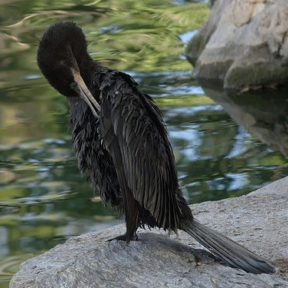

In [8]:
postp(srdata[0][1])

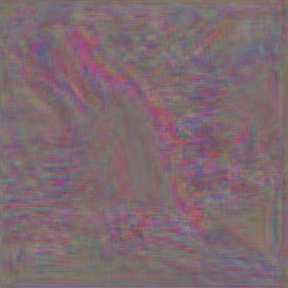

In [9]:
out = srnet(prep_img(srdata[0][0]))
postp(out.data.cpu()[0])

In [10]:
history = fit(srnet, srdata, criterion, optimizer, batch_size=8, num_workers=8)

Train on 5500 samples


[loss: 3.8183 ]



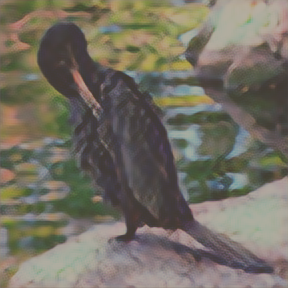

In [11]:
out = srnet(prep_img(srdata[0][0]))
postp(out.data.cpu()[0])

Train on 5500 samples


[loss: 3.3028 ]


[loss: 3.1790 ]



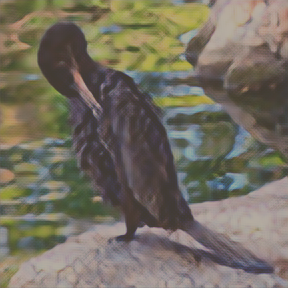

In [12]:
history = fit(srnet, srdata, criterion, optimizer, batch_size=8, num_workers=8, nb_epoch=2)
out = srnet(prep_img(srdata[0][0]))
postp(out.data.cpu()[0])

Train on 5500 samples


[loss: 3.1218 ]


[loss: 3.0850 ]



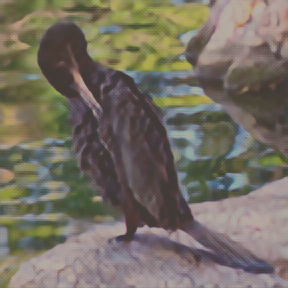

In [13]:
history = fit(srnet, srdata, criterion, optimizer, batch_size=8, num_workers=8, nb_epoch=2)
out = srnet(prep_img(srdata[0][0]))
postp(out.data.cpu()[0])

In [14]:
save_checkpoint(srnet.state_dict(), optimizer.state_dict(),'johnson_pl_bn_5epoch.pth.tar')

Train on 5500 samples


[loss: 3.0534 ]


[loss: 3.0530 ]



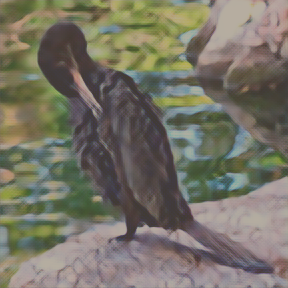

In [15]:
history = fit(srnet, srdata, criterion, optimizer, batch_size=8, num_workers=8, nb_epoch=2)
out = srnet(prep_img(srdata[0][0]))
postp(out.data.cpu()[0])

In [17]:
save_checkpoint(srnet.state_dict(), optimizer.state_dict(),'johnson_pl_bn_7epoch.pth.tar')

In [18]:
def anneal_lr(optimizer, decay):
    for param_group in optimizer.param_groups:
        param_group['lr'] /= decay

In [19]:
anneal_lr(optimizer, 2)

Train on 5500 samples


[loss: 2.9845 ]


[loss: 2.9724 ]


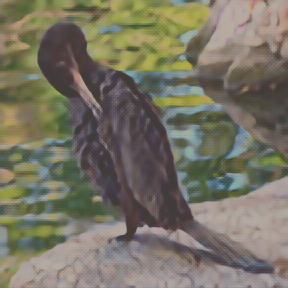

In [20]:
history = fit(srnet, srdata, criterion, optimizer, batch_size=8, num_workers=8, nb_epoch=2)
out = srnet(prep_img(srdata[0][0]))
postp(out.data.cpu()[0])

In [24]:
save_checkpoint(srnet.state_dict(), optimizer.state_dict(),'johnson_pl_bn_9epoch.pth.tar')

In [38]:
anneal_lr(optimizer, 2)

Train on 5500 samples


[loss: 2.9487 ]


[loss: 2.9478 ]



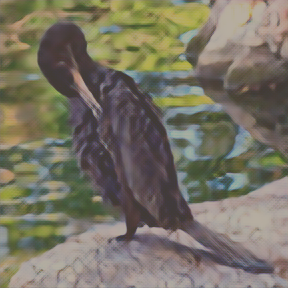

In [39]:
history = fit(srnet, srdata, criterion, optimizer, batch_size=8, num_workers=8, nb_epoch=2)
out = srnet(prep_img(srdata[0][0]))
postp(out.data.cpu()[0])

## Low Res Image

In [69]:
save_checkpoint(srnet.state_dict(), optimizer.state_dict(),'johnson_pl_bn_11epoch.pth.tar')

In [78]:
test_img = 900

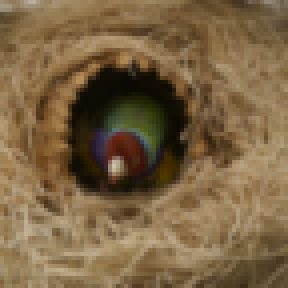

In [79]:
low = postp(srdata[test_img][0]).resize((288, 288))
# low.save('low_res_bird.jpg')
low

## Model output

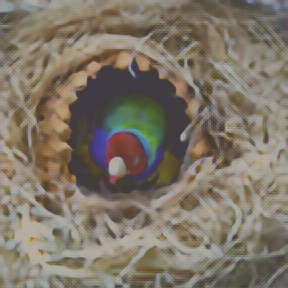

In [80]:
out = srnet(prep_img(srdata[test_img][0]))
out = postp(out.data.cpu()[0])
# out.save('output_bird.jpg')
out

## target

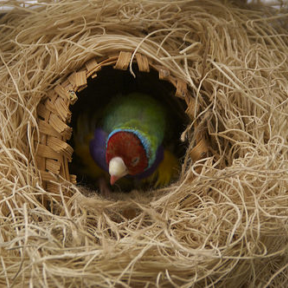

In [81]:
target = postp(srdata[test_img][1])
# target.save('target_bird.jpg')
target